In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists
sys.path.append("../..") 

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import Standardize

configure_plot_style()

# Load and prepare data

In [3]:
world = load_shapefile('world')
disasters = load_disaster_point_data()

# Select SA shape
central_america = [
    # "BLZ",  # Belize
    "CRI",  # Costa Rica
    "SLV",  # El Salvador
    "GTM",  # Guatemala
    "HND",  # Honduras
    "NIC",  # Nicaragua
    "PAN"   # Panama
]

# Define maps
ca_map = world.query('ISO_A3 in @central_america')

In [4]:
# Create predictions grid
ca_point_grid = load_grid_point_data(region='custom',
                                     grid_size=400, 
                                     force_reload = False,
                                     iso_list=central_america,
                                    file_reg_name = "central_america")


Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\central_america_points_400.shp\central_america_points_400.shp.shp


In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', 
                                                   multiplier=10, 
                                                   force_generate= False)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_10.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set to hydrometereological disasters
hydro_meteo = ["Hydrological", "Meteorological"]

df = df.rename(columns ={"Disaster Subgroup": "subgroup"} ).query('subgroup in @ hydro_meteo or is_disaster == 0')

In [11]:
#Delimiting data set columns
columns_to_use = ['ISO', 'Start_Year', "is_disaster",
               "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = (df[ list( set( columns_to_use).union(set(features)) )].dropna())

In [12]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create CA data sets

In [13]:
# Define dfs
ca_df = model_df.query('ISO in @central_america')

# Drop disaster points out of the map

ca_df =  ca_df.query('long < -75 & lat >0')

In [14]:
#Create the geodata set for sa disasters
ca_disasters = ca_df.query('is_disaster == 1')

ca_disasters_geo = gpd.GeoDataFrame(
                ca_disasters,
    geometry=gpd.points_from_xy(ca_disasters["long"], ca_disasters["lat"]), crs="EPSG:4326"
            )

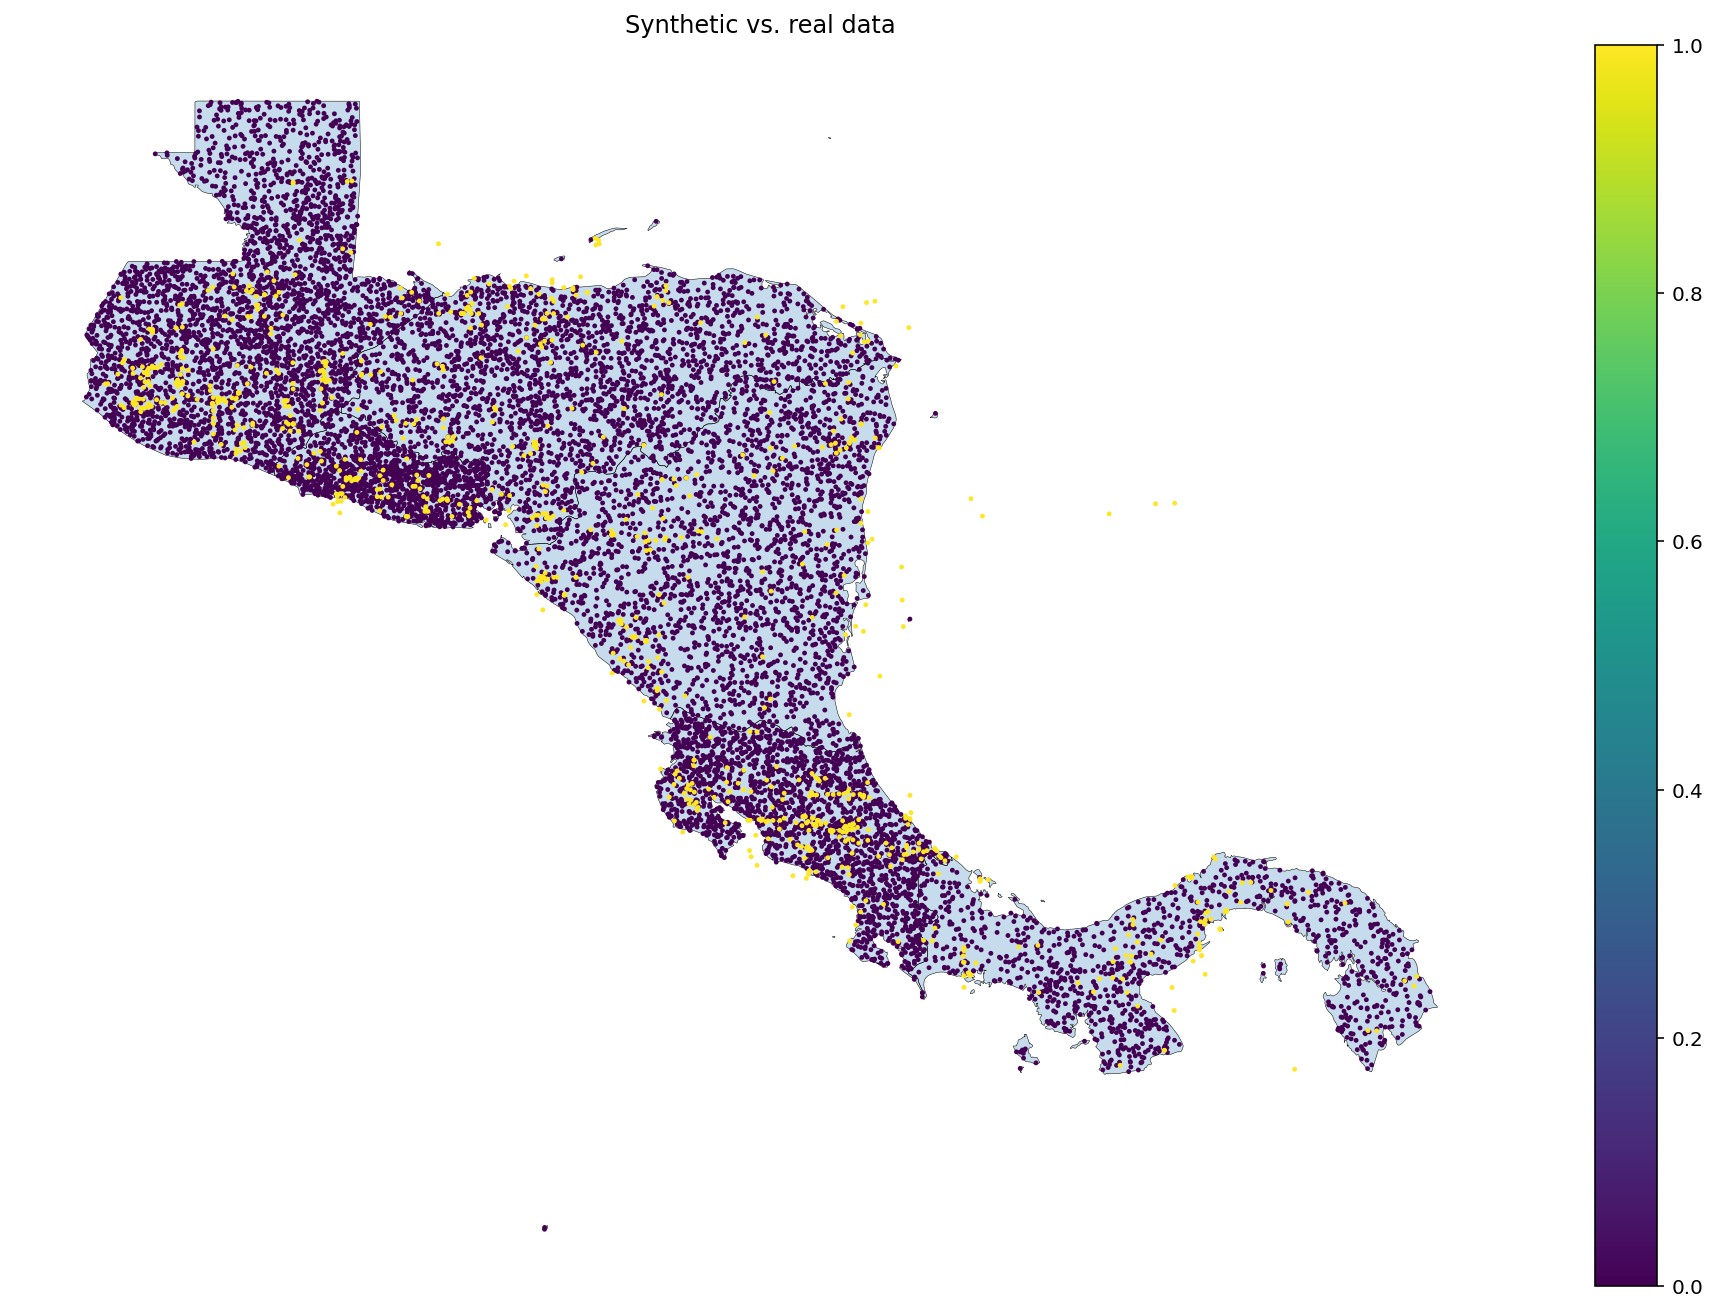

In [15]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @central_america ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @central_america').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

ca_df.plot("is_disaster",
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [16]:
#Tranform dfs to geopandas df
ca_df = gpd.GeoDataFrame(ca_df,  geometry=gpd.points_from_xy(ca_df["long"],
                                ca_df["lat"]),crs="EPSG:4326")


In [17]:
# Merge geospatial data with time varying data
# We create the merged ca_point_grid_extended for predictions
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in central_america:
    country_2020_data[country] = ca_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

country_2005_data = {}
country_2005_data_df = pd.DataFrame()
for country in central_america:
    country_2005_data[country] = ca_df.query('Start_Year == "2005-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2005_data_df = pd.concat([country_2005_data_df, country_2005_data[country]])

C:\Users\camil\AppData\Local\Temp\ipykernel_42536\3189642877.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = ca_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_42536\3189642877.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = ca_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_42536\3189642877.py:6: FutureWarning: The behavior

In [18]:
# Merge points with world ISO
ca_point_grid_extended = {}
ca_point_grid_extended_df = gpd.sjoin(ca_point_grid, ca_map, how="left", )
ca_point_grid_extended["2020"] = pd.merge(ca_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 
ca_point_grid_extended["2005"] = pd.merge(ca_point_grid_extended_df, country_2005_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" )


ca_point_grid_extended["2020"] = ca_point_grid_extended["2020"].rename(columns = {"lon" : "long"})
ca_point_grid_extended["2005"] = ca_point_grid_extended["2005"].rename(columns = {"lon" : "long"})

In [19]:
# Standardize SA data
transformer_stand_ =  Standardize().fit(ca_df)
ca_df_stand = transformer_stand_.transform(ca_df)

# other dfs
ca_point_grid_extended["2020"] = transformer_stand_.transform(ca_point_grid_extended["2020"]) 
ca_point_grid_extended["2005"] = transformer_stand_.transform(ca_point_grid_extended["2005"]) 

# Model on the SA data set: Full model

In [20]:
from laos_gggi.data_functions import load_all_data, load_emdat_data

In [21]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(ca_df["is_disaster"])
ISO_idx, ISO = pd.factorize(ca_df["ISO"]) 
obs_idx = ca_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(ca_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sa = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [22]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(ca_df["is_disaster"])
ISO_idx, ISO = pd.factorize(ca_df["ISO"]) 
obs_idx = ca_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(ca_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sa = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [23]:
with pm.Model(coords=coords_sa) as model_ca_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  ca_df_stand, )
    ISO_idx_pt = pm.Data("ISO_idx_pt", ISO_idx, dims= ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # HSGP process
    X_gp = pm.Data("X_gp", ca_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd),dims= ["obs_idx"])


    #Model mu
    mu = pm.Deterministic("mu", country_effect[ISO_idx_pt] +  X@beta + HSGP_component , dims= ["obs_idx"] )
    

    y_hat = pm.Bernoulli('y_hat', logit_p = mu, observed=Y, dims=['obs_idx'])

C:\Users\camil\AppData\Local\Temp\ipykernel_42536\169657033.py:18: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [24]:
if exists("model_ca_full.idata"):
    model_ca_full_idata = az.from_netcdf("model_ca_full.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_ca_full), backend="jax", gradient_backend='jax')
    model_ca_full_idata = nutpie.sample(compiled_model)
    #Save the idata
    az.to_netcdf(data = model_ca_full_idata, filename= pathlib.Path("model_ca_full.idata"))

### CA predictions

In [25]:
# full model WE predictions

# Rebuild ISO_idx_sa
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_sa=  ca_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

model_ca_full_idata_plot = {}

for year in ["2020", "2005"]:
    with model_ca_full.copy() as temp_model:
        #Declare data
        pm.set_data({"X_gp": ca_point_grid[["lat", "lon"]],
                     "Y": np.full(ca_point_grid_extended[year].shape[0], 0 ),
                     "X": ca_point_grid_extended[year][features_stand],
                     "ISO_idx_pt": ISO_idx_sa
     
                },
            coords= {"obs_idx": ca_point_grid_extended[year].index.values } 
           )
    
        y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))
    
    
    
    with freeze_dims_and_data(temp_model):
        model_ca_full_idata_plot[year] = pm.sample_posterior_predictive(model_ca_full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                             compile_kwargs= {"mode" : "JAX" })


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2D1929A8040>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2D196A29EE0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

In [26]:
# Create the geopandas version of the predictions
model_ca_full_predictions_geo = {}

for year in ["2020", "2005"]:
    model_ca_full_predictions_geo[year] = prediction_to_gpd_df(prediction_idata = model_ca_full_idata_plot[year] , 
                         variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                         points = ca_point_grid_extended['2020'].rename(columns = {"long": "lon"}) )

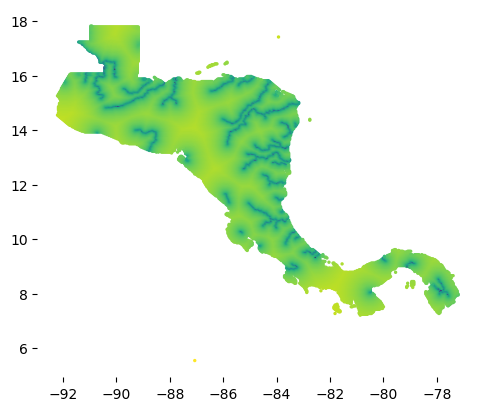

In [27]:
ca_point_grid_extended['2020'].plot("log_distance_to_river",markersize =2,);

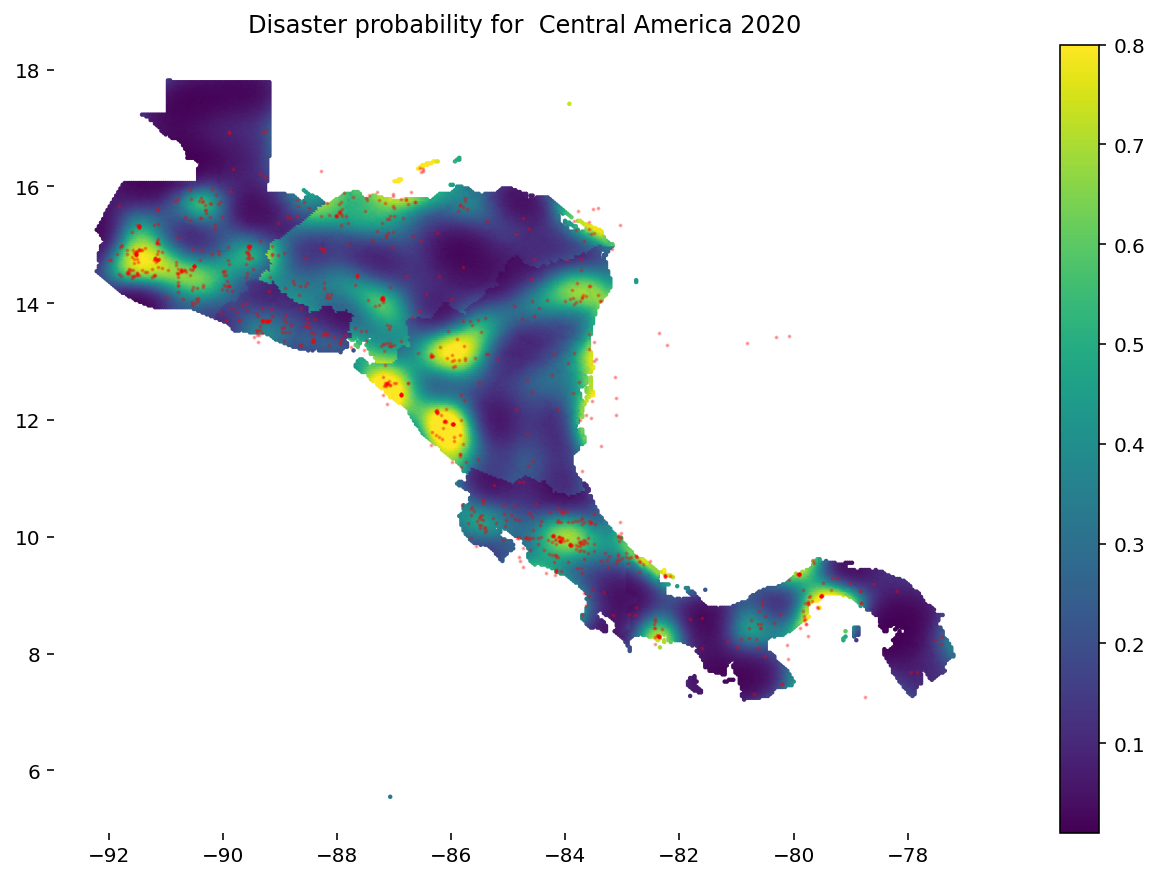

In [28]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_ca_full_predictions_geo["2020"]["y_hat"].plot("y_hat",legend=True, ax=ax,markersize = 1.5, vmax = 0.8,)
ca_disasters_geo.query('is_disaster == 1').plot(ax=ax, alpha = 0.3, c = "r", markersize =0.9, )
plt.title("Disaster probability for  Central America 2020", );

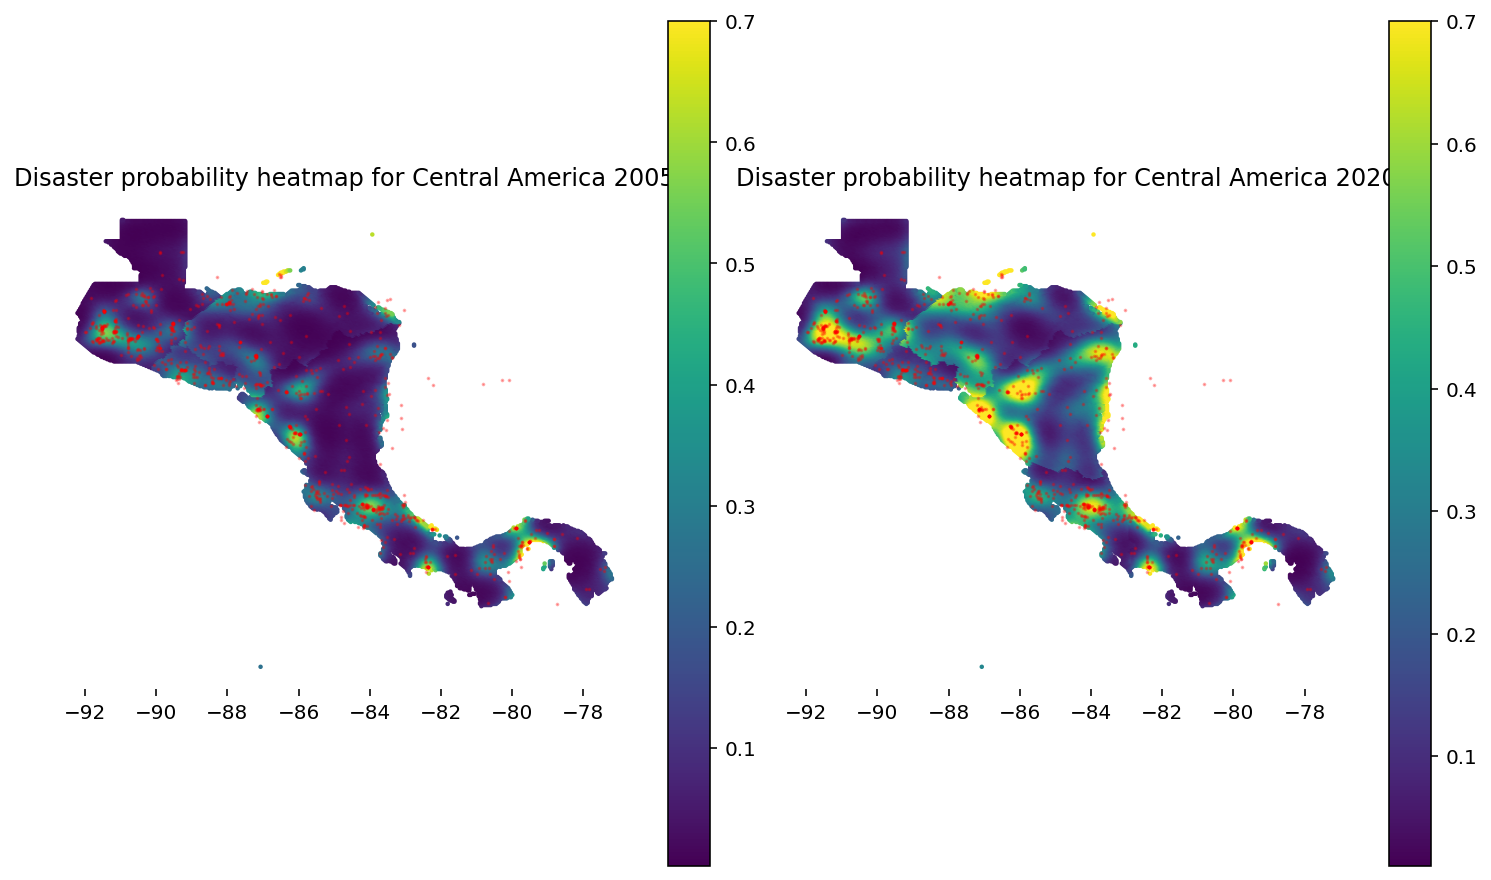

In [29]:
#Plot the predictions
fig, ax = plt.subplots(1,2, figsize=(10, 6), dpi= 144 )
for year, x in zip([ "2005", "2020"], [0,1]):
    model_ca_full_predictions_geo[year]["y_hat"].plot("y_hat",legend=True, ax=ax[x],markersize =1.5, vmax = 0.70)
    
    ca_disasters_geo.plot(ax=ax[x], alpha = 0.3, c = "r", markersize =0.7, )
    ax[x].get_yaxis().set_visible(False)
    ax[x].set_title(f"Disaster probability heatmap for Central America {year}", );